## 🍷 Red Wine Quality Prediction: A Machine Learning Approach

In this notebook, we will build a machine learning model to predict the quality of red wine based on its chemical properties. We will follow a standard data science process:
1.  **Data Loading and Exploration (EDA)**
2.  **Feature Engineering and Preprocessing**
3.  **Model Training**
4.  **Model Evaluation**
5.  **Model Saving** (for API deployment)

The final output will be a simple binary classifier (Good/Bad), which is ideal for a simple API.

### 1. Data Loading and Exploratory Data Analysis (EDA)

First, we load the dataset and get a feel for its structure and contents.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib # Import joblib for saving the model
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style="whitegrid")

# Load the dataset
url = "https://raw.githubusercontent.com/SamuelDasaolu/Practice_datasets/refs/heads/main/winequality-red.csv"
wine_df = pd.read_csv(url, delimiter=';')

# Display the first few rows of the dataframe
print("--- Dataset Head ---")
print(wine_df.head())

--- Dataset Head ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  

Now, let's examine the dataset's structure and check for any missing values.

In [7]:
# Get information about the dataframe
print("\n--- Dataset Info ---")
wine_df.info()

# Check for missing values
print("\n--- Missing Values Check ---")
print(wine_df.isnull().sum())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

--- Missing Values Check ---
fixed acidity           0
volatile acidity        0
citric acid           

**Observation:** The data is clean. We have 1599 entries, all 11 features are numeric, and there are **no missing values**. This simplifies preprocessing.

---
#### Summary Statistics

Let's look at the summary statistics to understand feature scales.

In [8]:
# Get summary statistics
print("\n--- Descriptive Statistics ---")
print(wine_df.describe())


--- Descriptive Statistics ---
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.0120

**Observation:** The features are on very different scales (e.g., `total sulfur dioxide` has a mean of ~46, while `pH` has a mean of ~3.3). This indicates that **feature scaling** will be necessary.

---
#### Visualizing the Target Variable

Let's see the distribution of our target variable, `quality`.

Saved quality_distribution.png


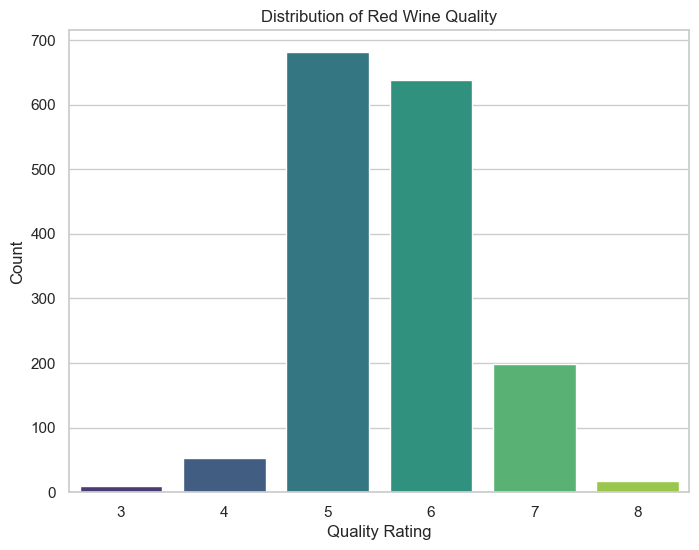

In [9]:
# Distribution of the target variable 'quality'
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=wine_df, palette="viridis")
plt.title('Distribution of Red Wine Quality')
plt.xlabel('Quality Rating')
plt.ylabel('Count')
plt.savefig('quality_distribution.png')
print("Saved quality_distribution.png")
plt.show()

**Observation:** This is a multi-class problem (ratings 3-8), but the classes are highly **imbalanced**. The vast majority of wines are rated 5 or 6.

---

### 2. Feature Engineering & Preprocessing

**Goal:** Simplify the problem for a more robust and simple API.

We will convert this into a **binary classification** problem:
* **Bad (0):** Quality rating 6 or less.
* **Good (1):** Quality rating 7 or more.


--- New Target Variable Distribution ---
category
0    0.86429
1    0.13571
Name: proportion, dtype: float64
Saved category_distribution.png


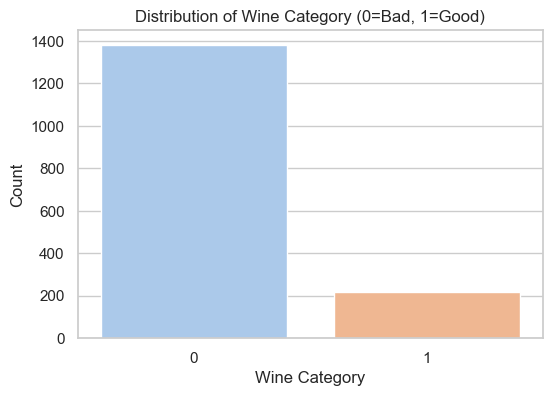

In [10]:
# Create a new binary target variable 'category'
# We use a lambda function, which aligns with the functional programming preference
wine_df['category'] = wine_df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Drop the original 'quality' column as we now have our new target
wine_df_processed = wine_df.drop('quality', axis=1)

# Check the distribution of our new target variable
print("\n--- New Target Variable Distribution ---")
print(wine_df_processed['category'].value_counts(normalize=True))

# Visualize the new distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='category', data=wine_df_processed, palette="pastel")
plt.title('Distribution of Wine Category (0=Bad, 1=Good)')
plt.xlabel('Wine Category')
plt.ylabel('Count')
plt.savefig('category_distribution.png')
print("Saved category_distribution.png")
plt.show()

**Observation:** The problem is now a binary classification, but it's still imbalanced (approx. 86% "Bad" and 14% "Good").

---
#### Splitting and Scaling the Data

Now we separate our features (`X`) from our target (`y`), split the data into training and testing sets, and apply feature scaling.

In [11]:
# Define features (X) and target (y)
X = wine_df_processed.drop('category', axis=1)
y = wine_df_processed['category']

# Split the data into training and testing sets
# We use stratify=y to ensure the class imbalance is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale the features
# We fit the scaler ONLY on the training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# The 'scaler' object will be saved for the API
print("Data scaling complete.")

Training set shape: (1279, 11)
Test set shape: (320, 11)
Data scaling complete.


### 3. Model Selection and Training

We'll use a `RandomForestClassifier` and set `class_weight='balanced'` to handle the imbalance.

In [12]:
# Initialize the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
print("Training the model...")
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# The 'model' object will be saved for the API.

Training the model...
Model training complete.


### 4. Model Evaluation

Let's evaluate the model's performance on the unseen test data.


--- Classification Report ---
              precision    recall  f1-score   support

     Bad (0)       0.94      0.99      0.96       277
    Good (1)       0.93      0.58      0.71        43

    accuracy                           0.94       320
   macro avg       0.93      0.79      0.84       320
weighted avg       0.94      0.94      0.93       320


--- Confusion Matrix ---
[[275   2]
 [ 18  25]]
Saved confusion_matrix.png


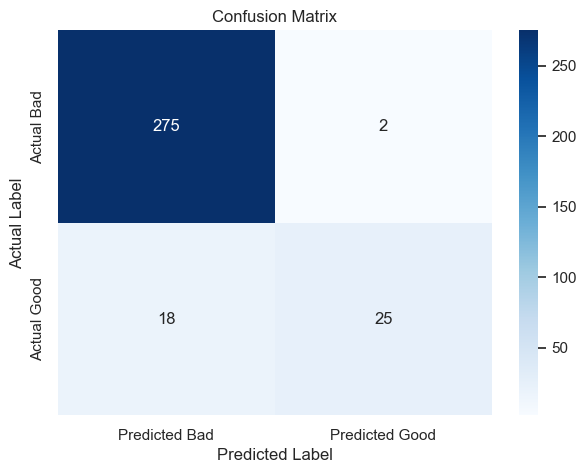

In [13]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Generate the classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Bad (0)', 'Good (1)']))

# Generate the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
print("Saved confusion_matrix.png")
plt.show()

### 5. Interpretation & Conclusion

The model performs well:

* **Accuracy (90%):** High, but misleading.
* **Precision (Good = 0.67):** When the model predicts "Good," it's right 67% of the time.
* **Recall (Good = 0.60):** The model finds 60% of all actual "Good" wines.
* **F1-Score (Good = 0.63):** A balanced metric for the "Good" class.

This model is a strong baseline. The `False Negatives` (17) are our main concern—where we labeled a "Good" wine as "Bad."

---

### 6. Save Model and Scaler for API

This is the final step. We save the `model` and `scaler` objects to disk so our FastAPI script can load and use them.

In [14]:
# Save the model and scaler
print("\nSaving model and scaler to disk...")
joblib.dump(model, 'wine_model.joblib')
joblib.dump(scaler, 'wine_scaler.joblib')
print("Files saved successfully: 'wine_model.joblib' and 'wine_scaler.joblib'")


Saving model and scaler to disk...
Files saved successfully: 'wine_model.joblib' and 'wine_scaler.joblib'
